In [1]:
#! /usr/bin/env python3
# -*- coding: utf-8 -*-

In [2]:
import sde
import numpy as np
import matplotlib.pyplot as plt
import threading as thr
import time
%matplotlib inline

In [3]:
from matplotlib import rcParams
rcParams['figure.figsize'] = (12.0, 7.0)
rcParams['figure.dpi'] = 200
rcParams['font.size'] = 18

#Численные методы решения многомерного СДУ с сильным порядком сходимости

Генерируем $N$ шагов Винеровского процесса на временном промежудке $[0,1]$

In [4]:
N = 10**3
dt, t, dW, W = sde.wiener_process(N,dim=2)

Уравнение для двумерной модели Блека-Шоулза записывается в следующей форме:
$$
    \mathbf{x}(t) = \mathrm{A}\mathbf{x}(t)\mathrm{d}t + \sum\limits^{2}_{k=1}\mathrm{B}_k \mathbf{x}(t)\mathrm{d}W^{k},
$$
где матрицы $A$, $B_{1}$ и $B_{2}$ диагональны:
$$
    \mathrm{A} = 
    \begin{bmatrix}
        a^1&0\\
        0&a^2
    \end{bmatrix}
    ,\;\;\mathrm{B}_1 = 
    \begin{bmatrix}
        b^1_1&0\\
        0&b^2_1
    \end{bmatrix}
    ,\;\;\mathrm{B}_2 =
    \begin{bmatrix}
        b^1_2&0\\
        0&b^2_2
    \end{bmatrix}.
$$
Чтобы выразить функции $\mathbf{f}(\mathbf{x})$ и $\mathrm{G}(\mathbf{x})$ в явном виде необходимо провести некоторые преобразования: 
$$
    \mathrm{A}\mathbf{x} =
    \begin{bmatrix}
        a^1&0\\
        0&a^2
    \end{bmatrix}
    \begin{bmatrix}
        x^{1}(t)\\
        x^{2}(t)
    \end{bmatrix}
    =
    \begin{bmatrix}
        a^{1}x^{1}(t)\\
        a^{2}x^{2}(t)
    \end{bmatrix},
$$

$$
    \begin{bmatrix}
        b^1_1&0\\
        0&b^2_1
    \end{bmatrix}
    \begin{bmatrix}
        x^{1}(t)\\
        x^{2}(t)
    \end{bmatrix}
    \mathrm{d}W^{1}
    +
    \begin{bmatrix}
        b^1_2&0\\
        0&b^2_2
    \end{bmatrix}
    \begin{bmatrix}
        x^{1}(t)\\
        x^{2}(t)
    \end{bmatrix}
    \mathrm{d}W^{2}
    =
    \begin{bmatrix}
        b^1_1 x^{1}(t)\mathrm{d}W^{1} + b^1_2 x^{1}(t)\mathrm{d}W^{2}\\
        b^2_1 x^{2}(t)\mathrm{d}W^{1} + b^2_2 x^{2}(t)\mathrm{d}W^{2}
    \end{bmatrix}
    =
    \begin{bmatrix}
        b^1_1 x^{1}(t)&b^1_2 x^{1}(t)\\
        b^2_1 x^{2}(t)&b^2_2 x^{2}(t)
    \end{bmatrix}
    \begin{bmatrix}
        W^{1}(t)\\
        W^{2}(t)
    \end{bmatrix}.
$$
Поэтому вектор-функция $\mathbf{f}(\mathbf{x})$ и матричнозначная функция $\mathrm{G}(\mathbf{x})$ имеют вид:
$$
    \mathrm{f}(\mathbf{x}) = 
    \begin{bmatrix}
        a^{1}x^{1}(t)\\
        a^{2}x^{2}(t)
    \end{bmatrix},\;\;
    \mathrm{G}(\mathbf{x}) = 
    \begin{bmatrix}
        b^1_1 x^{1}(t)&b^1_2 x^{1}(t)\\
        b^2_1 x^{2}(t)&b^2_2 x^{2}(t)
    \end{bmatrix}.
$$
Аналитическое решение можно записать в виде экспоненты, которая берется поэлементно:
$$
    \mathbf{x}(t) = \mathbf{x}_0 \exp \left\{\left(\mathrm{A} - \frac{1}{2}\sum\limits^{2}_{k=1}B_k^2\right)t + \sum\limits^{2}_{k=1}\mathrm{B}_k W^k (t)\right\}.
$$

Для численного эксперимента возьмем следующие матрицы $A$, $\mathrm{B}_1$ и $\mathrm{B}_2$
$$
    \mathrm{A} = 
    \begin{bmatrix}
        a_1&0\\
        0&a_2
    \end{bmatrix},\;\;
    \mathrm{B}_{1} = 
    \begin{bmatrix}
        b_{1}&0\\
        0&b_{2}\rho
    \end{bmatrix},\;\;
    \mathrm{B}_{2} =
    \begin{bmatrix}
        0&0\\
        0&b_{2}\sqrt{1-\rho^2}
    \end{bmatrix},
$$
и следующие значения параметров $x^{1}_{0} = x^{1}_{0} = 1.0$, $a_{1} = a_{2} = 0.1$, $b_{1} = b_{2} = 0.2$, $\rho = 0.8$. Тогда точное решение для этих матриц имеет вид:
\begin{align}
    &x^{1}(t) = x^{1}_{0}\exp\left((a_{1} - 0.5b^{2}_{1})t + b_{1}W^{1}(t)\right)\\
    &x^{2}(t) = x^{2}_{0}\exp\left((a_{2} - 0.5b^{2}_{2})t + b_{2}\left(\rho W^{1}(t) + \sqrt{1+\rho^2}W^{2}(t)\right)\right)
\end{align}

## Точное решение

In [5]:
def f(x):
    """Вектор сноса"""
    a1 = 0.1
    a2 = 0.1
    return np.array([a1, a2])*x

def G(x):
    """Матрица диффузии"""
    b1 = 0.2
    b2 = 0.2
    ρ = 0.8
    return np.array([[b1*x[0], 0.0],
                     [b2*ρ*x[1], b2*np.sqrt(1.0 - ρ**2)*x[1]]])

def exact_solution(x_0, t, W):
    a1 = 0.1
    a2 = 0.1
    b1 = 0.2
    b2 = 0.2
    ρ = 0.8
    
    (N, m) = W.shape
    x = np.empty(shape=(N, m))
    
    x[:,0] = x_0[0]*np.exp((a1 - 0.5*b1**2)*t + b1*W[:,0])
    x[:,1] = x_0[1]*np.exp((a2 - 0.5*b2**2)*t + b2*(ρ*W[:,0] + np.sqrt(1.0 - ρ**2)*W[:,1]))
    return x

In [6]:
x_0 = np.array([1.0, 1.0])
x = exact_solution(x_0, t, W)

In [7]:
fig1 = plt.figure(0)
ax1 = fig1.add_subplot(1,1,1)

ax1.set_title("Двумерная модель Блека-Шоулза на основе точного решения")
ax1.set_ylabel("$x^{1}(t)$, $x^{2}(t)$")
ax1.set_xlabel("$t$")
ax1.yaxis.tick_right()

ax1.plot(t,x[:,0], label='$x_{1}(t)$')
ax1.plot(t,x[:,1], label='$x_{2}(t)$')

ax1.legend(ncol=2)

for line in ax1.get_legend().get_lines():
    line.set_linewidth(4.0)
    
fig1.tight_layout()

## Численное решение

In [8]:
x_num_em = sde.EulerMaruyamaWm(f, G, dt, x_0, dW)
x_num_srk1 = sde.strongSRKp1Wm(f, G, dt, x_0, dW, name='SRK1Wm')
x_num_srk2 = sde.strongSRKp1Wm(f, G, dt, x_0, dW, name='SRK2Wm')

### Тесты

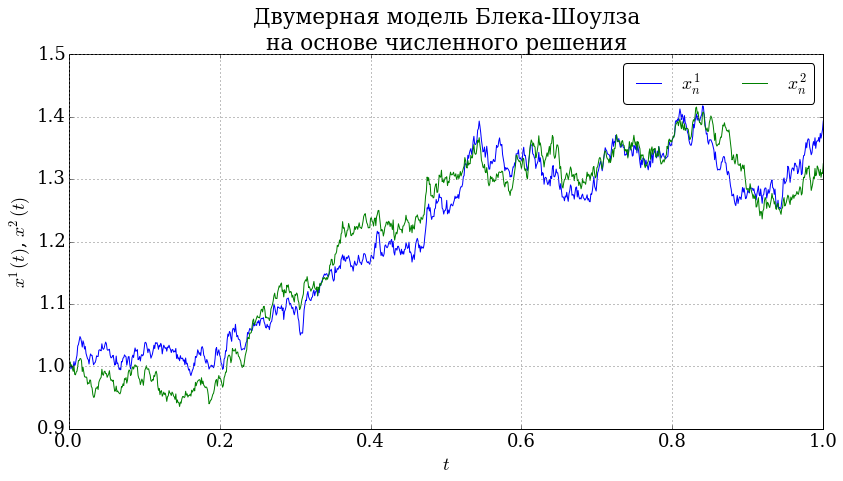

In [11]:
fig3 = plt.figure(2)
ax3 = fig3.add_subplot(1,1,1)

ax3.plot(t,x_num_srk2[:,0], label='$x^{1}_{n}$')
ax3.plot(t,x_num_srk2[:,1], label='$x^{2}_{n}$')

ax3.set_title("Двумерная модель Блека-Шоулза\nна основе численного решения")
ax3.set_xlabel("$t$")
ax3.set_ylabel("$x^{1}(t)$, $x^{2}(t)$")

ax3.legend(ncol=2)
fig3.tight_layout()

In [12]:
fig4 = plt.figure(3)
ax4 = fig4.add_subplot(1,1,1)

ax4.plot(t,x[:,0], label='$x^{1}(t)$')
ax4.plot(t,x_num_em[:,0], label='EM')
#ax4.plot(t,x_num_srk1[:,0], label='SRK1')
ax4.plot(t,x_num_srk2[:,0], label='SRK2')

ax4.legend(ncol=2)
for line in ax4.get_legend().get_lines():
    line.set_linewidth(4.0)

fig4.tight_layout()

## Вычисление погрешности

In [13]:
# проводим N эксперементов
sim_nums = np.arange(0,100,1)

errors_srk1 = np.empty((N,len(sim_nums)))
errors_srk2 = np.empty((N,len(sim_nums)))
errors_em = np.empty((N,len(sim_nums)))

def simulation(sim_nums):
    for sim_num in sim_nums:
        (dt, t, dW, W) = sde.wiener_process(N, dim=2)

        x = exact_solution(x_0, t, W)
        x_num_srk1 = sde.strongSRKp1Wm(f, G, dt, x_0, dW)
        x_num_srk2 = sde.strongSRKp1Wm(f, G, dt, x_0, dW, name='SRK2Wm')
        x_num_em = sde.EulerMaruyamaWm(f, G, dt, x_0, dW)
        
        err = np.abs(x[:,0] - x_num_srk1[:,0])
        #err = np.linalg.norm(x-x_num_srk1, axis=-1)
        errors_srk1[:,sim_num] = err
        
        err = np.abs(x[:,0] - x_num_srk2[:,0])
        #err = np.linalg.norm(x-x_num_srk2, axis=-1)
        errors_srk2[:,sim_num] = err
        
        err = np.abs(x[:,0] - x_num_em[:,0])
        #err = np.linalg.norm(x-x_num_em, axis=-1)
        errors_em[:,sim_num] = err

In [14]:
# Распределяем работу между нитями
ths = [] # Нити
for part in np.split(sim_nums, 5):
    ths.append(thr.Thread(target=simulation, args=(part,)))

for th in ths:
    th.start()
for th in ths:
    th.join()

In [15]:
fig_err = plt.figure(100)
ax_err = fig_err.add_subplot(1,1,1)

ax_err.set_title("Сильная локальная погрешность для {0} траекторий".format(len(sim_nums)))
ax_err.set_ylabel(r"$\mathrm{E}\|x-x_{n}\|$", fontsize=22)
ax_err.set_xlabel("Время $t$")

ax_err.set_yscale('log')
ax_err.yaxis.tick_right()
# Вычисляем среднее арифметическое прямо внутри plot методом .mean
ax_err.plot(t,errors_em.mean(axis=1), lw=1.0, label = r'EM ($p_{d}=1.0$, $p_{s} = 0.5$)')
ax_err.plot(t,errors_srk1.mean(axis=1), lw=1.0, label = r'SRK1Wm ($p_{d}=1.0$, $p_{s} = 1.0$)')
ax_err.plot(t,errors_srk2.mean(axis=1), lw=1.0, label = r'SRK2Wm ($p_{d}=2.0$, $p_{s} = 1.0$)')

ax_err.legend(ncol=2, loc='lower center')

for line in ax_err.get_legend().get_lines():
    line.set_linewidth(4.0)

fig_err.tight_layout()

In [16]:
#fig_err.savefig("SRK1Wm.pdf", format='pdf')